In [1]:
#we will be implementing a regression network that will predict the proteomics of a protein given its metabolomics
#10/12/23

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [2]:
# Load the Metabolomics data
metabolomics_file_path = 'UKBB_300K_Overlapping_MET.csv'
metabolomics_df = pd.read_csv(metabolomics_file_path, index_col=0)

# Load the Proteomics data (Olink)
proteomics_file_path = 'UKBB_300K_Overlapping_OLINK.csv'
proteomics_df = pd.read_csv(proteomics_file_path, index_col=0)


#turn to numpy array
met = metabolomics_df.to_numpy()
prot = proteomics_df.to_numpy()
print(met.shape, prot.shape)

#impute data using mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(prot)
prot = imp.transform(prot)
def z_score_normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean)/std

p = z_score_normalize(prot)
m = z_score_normalize(met)

#now train test split
X_train, X_test, y_train, y_test = train_test_split(m, p, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27337, 251) (27337, 1461)
(21869, 251) (5468, 251) (21869, 1461) (5468, 1461)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl

%env CUDA_LAUNCH_BLOCKING=1
#%env TORCH_USE_CUDA_DSA=1

torch.set_float32_matmul_precision('medium')

# Check for CUDA availability and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader objects for easier batching of data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #numworkers is 0 for now, because we at high ram usage

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class Net(pl.LightningModule):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(251, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1461)
        self.losses = []

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation on final layer as it's a regression task
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.losses.append(loss)
        return {'test_loss': loss}

    def on_test_end(self):
        avg_loss = torch.stack([x for x in self.losses]).mean()
        print(f'avg_test_loss: {avg_loss}')
        #self.log('avg_test_loss', avg_loss)

model = Net()

trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1)  # Set the number of epochs and gpus
#print(torch.cuda.memory_allocated(device))


env: CUDA_LAUNCH_BLOCKING=1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sarthak/mambaforge/envs/krumsiek_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [4]:
trainer.fit(model, train_loader, test_loader)  # Train the model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 129 K 
1 | fc2  | Linear | 262 K 
2 | fc3  | Linear | 749 K 
--------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.565     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sarthak/mambaforge/envs/krumsiek_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/sarthak/mambaforge/envs/krumsiek_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 684/684 [00:07<00:00, 91.37it/s, v_num=21] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 684/684 [00:07<00:00, 90.98it/s, v_num=21]


In [5]:
trainer.test(model, dataloaders=test_loader)  # Test the model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sarthak/mambaforge/envs/krumsiek_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 171/171 [00:00<00:00, 304.36it/s]
avg_test_loss: 0.8826842904090881


[{}]

In [15]:
#now let's do the next step of evaluating the model to plot the regression

#first, let's get the predictions
y_pred = model(X_test_tensor.cpu()).detach().numpy()

In [16]:
def plot_fct(y_pred, y_test, mse_idx, mse):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    for i, feature_idx in enumerate(mse_idx):
        ax = axs[i]
        ax.scatter(y_test[:, feature_idx], y_pred[:, feature_idx], alpha=0.5)
        ax.plot([min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
                [min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
                color='red', linestyle='--')
        R2 = np.corrcoef(y_test[:, feature_idx], y_pred[:, feature_idx])[0, 1] ** 2
        ax.set_title(f'Feature {feature_idx} (MSE: {mse[feature_idx]:.4f}, R2: {R2:.4f})')
        ax.set_xlabel('True Value')
        ax.set_ylabel('Predicted Value')

    plt.tight_layout()
    plt.show()

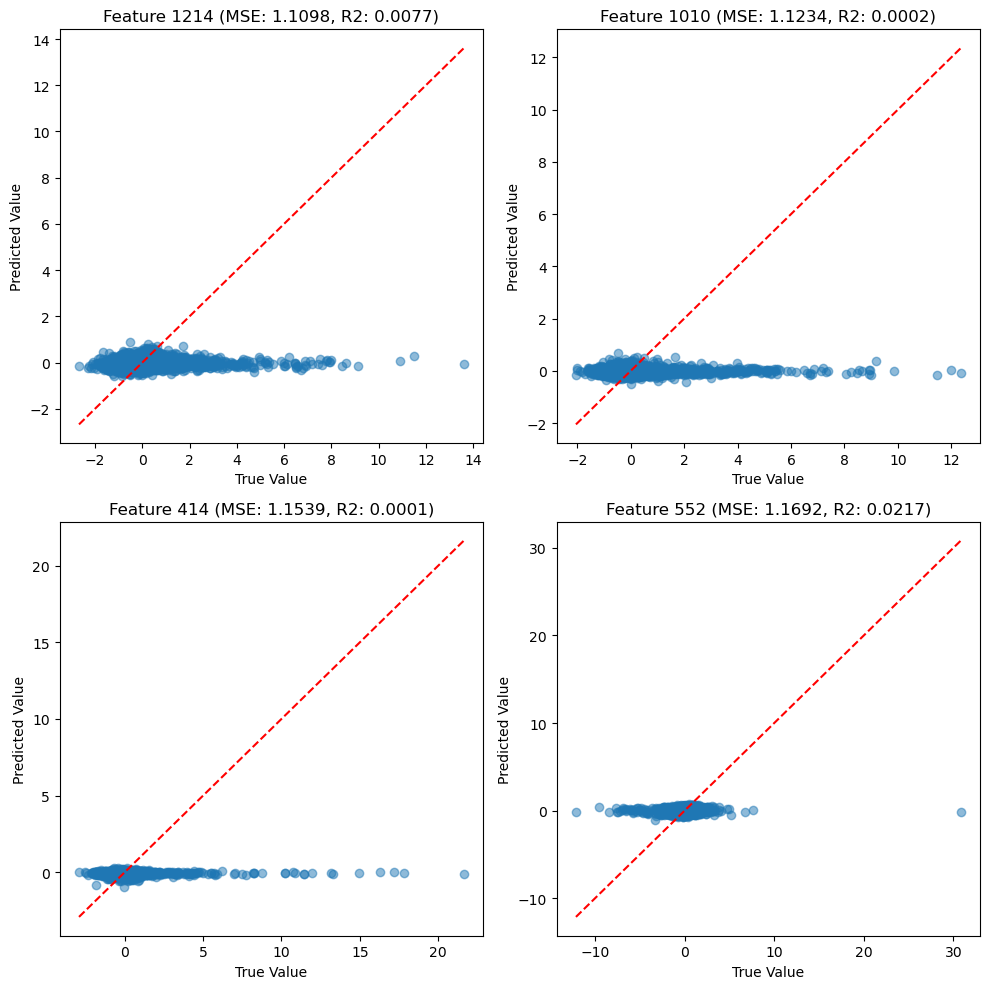

In [17]:
#now plot the regression
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

highest_mse = np.argsort(mse)[-4:]

lowest_mse = np.argsort(mse)[:4]

plot_fct(y_pred, y_test, highest_mse, mse)

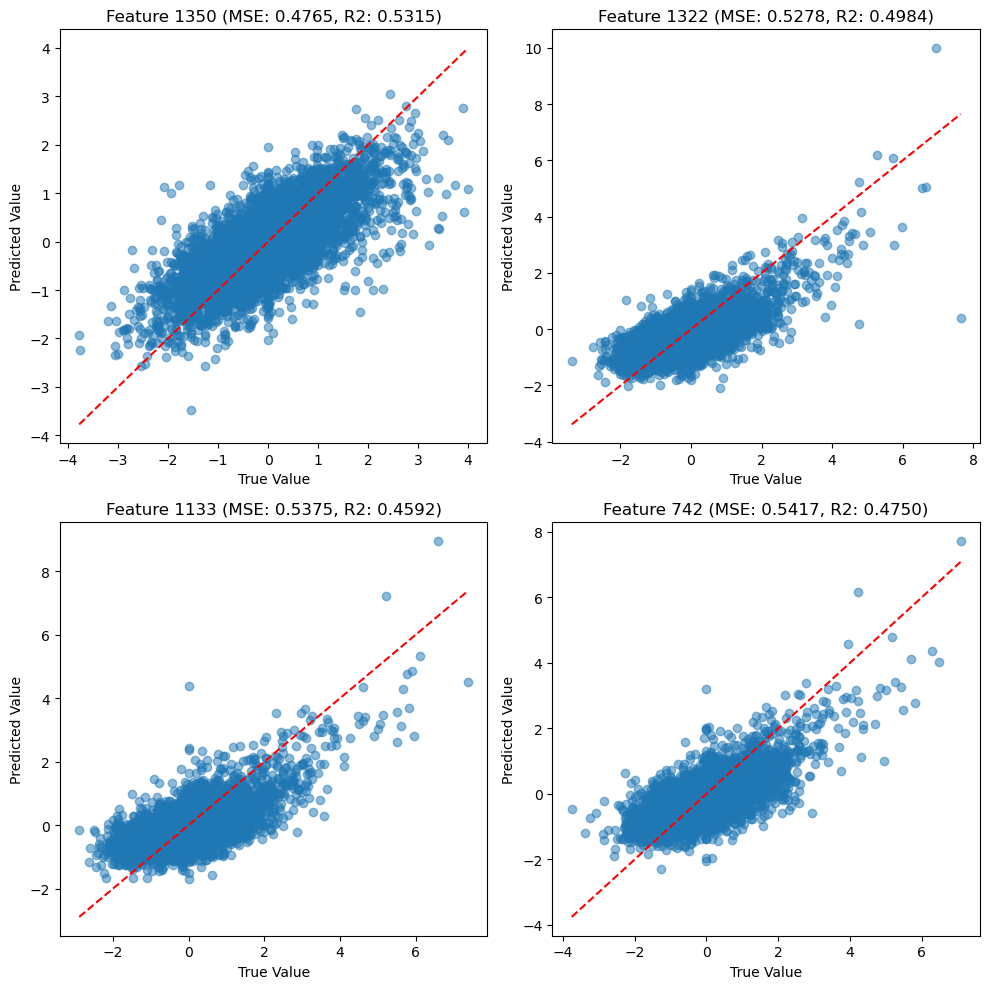

In [18]:
plot_fct(y_pred, y_test, lowest_mse, mse)

# try 2, now with k fold

In [3]:
#load in data again, but use utils
import os
os.chdir('/home/sarthak/cornell/Krumsiek/')
from utils import LoadData

dataclass = LoadData(preprocess = True, impute = True)
m = dataclass.m
p = dataclass.p

print(m.shape, p.shape)

(27337, 251) (27337, 1461)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl

#%env CUDA_LAUNCH_BLOCKING=1
#%env TORCH_USE_CUDA_DSA=1

torch.set_float32_matmul_precision('medium')

# Check for CUDA availability and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader objects for easier batching of data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #numworkers is 0 for now, because we at high ram usage

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class Net(pl.LightningModule):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(251, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1461)
        self.losses = []

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation on final layer as it's a regression task
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.losses.append(loss)
        return {'test_loss': loss}

    def on_test_end(self):
        avg_loss = torch.stack([x for x in self.losses]).mean()
        print(f'avg_test_loss: {avg_loss}')
        #self.log('avg_test_loss', avg_loss)

model = Net()

trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1)  # Set the number of epochs and gpus
#print(torch.cuda.memory_allocated(device))


#done in test_pipeline3.ipynb